In [1]:
import torch
from torch.utils.data import Dataset
from binconvfm.models.lstm import LSTMForecaster
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
class Seq2SeqDataset(Dataset):
    def __init__(self, seq, input_len=24, output_len=5, n_samples=1000):
        self.input_len = input_len
        self.output_len = output_len
        self.n_samples = n_samples
        self.seq = torch.tensor(seq, dtype=torch.float32)
        self.length = len(seq) - input_len - output_len + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        input_seq = self.seq[idx : idx + self.input_len]
        target_seq = self.seq[idx + self.input_len : idx + self.input_len + self.output_len]
        return input_seq, self.output_len, self.n_samples, target_seq

In [3]:
x_space = np.linspace(0, 100, 1000)
seq = np.sin(x_space) + np.random.randn(1000)*0.1

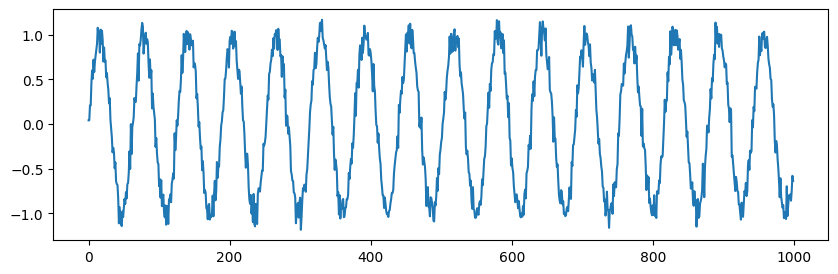

In [4]:
plt.figure(figsize=(10, 3))
plt.plot(seq)
plt.show()

In [5]:
input_len = 100
output_len = 50

train_dataset = Seq2SeqDataset(seq, input_len, output_len)
val_dataset = Seq2SeqDataset(seq, input_len, output_len)
test_dataset = Seq2SeqDataset(seq, input_len, output_len)

In [45]:
model = LSTMForecaster(hidden_dim=64, num_epochs=5)
model.fit(train_dataset, val_dataset)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LSTM | 17.2 K | train
---------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [46]:
model.evaluate(test_dataset)

Testing: |                                                                                                 | 0…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          crps              0.09670302271842957
          mase              1.8612128496170044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mase': 1.8612128496170044, 'crps': 0.09670302271842957}]

In [47]:
pred = model.predict(test_dataset)
pred[0].shape

Predicting: |                                                                                              | 0…

torch.Size([1000, 50])

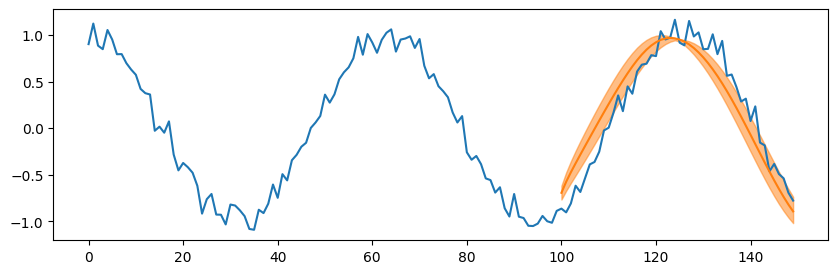

In [48]:
idx = torch.randint(len(test_dataset), (1,)).item()
input_seq, horizon, n_samples, target_seq = test_dataset[idx]
q = torch.tensor([0.01, 0.5, 0.99])
pred_seq = torch.quantile(pred[idx], q=q, dim=0)

plt.figure(figsize=(10, 3))
plt.plot(range(input_len+output_len), torch.concat([input_seq, target_seq]))
plt.plot(range(input_len, input_len+output_len), pred_seq[1])
plt.fill_between(range(input_len, input_len+output_len), pred_seq[0], pred_seq[2], alpha=0.5, color='tab:orange')
plt.show()